Notebook detailing the implementation of the jet core detection method originally introduced in Manney et al. 2011

## load in libraries

In [1]:
import numpy as np
import xarray as xr
import scipy.ndimage # used for labelling connected regions of windspeed above threshold
import matplotlib.pyplot as plt

import jsmetrics
from jsmetrics.utils import data_utils, spatial_utils, windspeed_utils

print("jsmetrics version", jsmetrics.__version__)
print("xarray version", xr.__version__)

jsmetrics version 0.2.1-beta
xarray version 2023.3.0


## load in data

In [2]:
ua = xr.open_dataset('../jsmetrics-examples/data/era5_u_wind_JF21.nc')
va = xr.open_dataset('../jsmetrics-examples/data/era5_v_wind_JF21.nc')

In [3]:
## merge u and v wind components
uava = xr.merge([ua, va])

In [4]:
## this is necessary because jsmetrics currently only accept standardised names as input
uava = uava.rename({'longitude':'lon', 'latitude':'lat', 'level':'plev', 'u':'ua', 'v':'va'})


In [5]:
## calculate windspeed from u and v wind components
uava['ws'] = windspeed_utils.get_resultant_wind(uava['ua'],uava['va'])

In [6]:
## global variable for plev limit on jet core detection
jet_core_plev_limit = (100, 400)

In [7]:
jet_core_ws_threshold=40
jet_boundary_ws_threshold=30

In [8]:
## get potential regions of jet cores and regions by only selecting above thresholds 
uava['potential_jet_cores'] = uava['ws'].where(lambda val: (val>=jet_core_ws_threshold) & (val.plev >= min(jet_core_plev_limit)) & (val.plev <= max(jet_core_plev_limit)), 0)
uava['potential_jet_regions'] = uava['ws'].where(lambda val: val>=jet_boundary_ws_threshold, 0)

In [9]:
## for the example in this notebook load in only one day
ws_slice = uava.isel(time=-1).load()

### Step 1. Find local maxima within 2-d array
This is an implementation of the local maxima detection in M11 (only checks neighbours left, right, above and below)

In [10]:
def add_pad_to_array(arr, pad_width=1, constant_values=0):
    """
    Add a edge of constant values around a numpy array
    
    Parameters
    ----------
    arr : array-like
        A 2-D array with numeric values (i.e. dtypes float or int)
    pad_width : int
        Width of values to add to edges (default: 1)
    constant_values : int
        Value to add to edges (default: 0)
        
    Returns
    ----------
    padded_arr : array-like
        A 2-D array with new dimensions as a pad has been added at the edges
    """
    padded_arr = np.pad(arr, pad_width, mode='constant', constant_values=constant_values)
    return padded_arr

    
def find_local_maxima_in_2d_dataarray(arr):
    """
    Find indices of local maximas within a 2-D array. Should return two values which relate to the position of local maximas (if any).

    Component of method of algorithm originally introduced in Manney et al. (2011) https://doi.org/10.5194/acp-11-6115-2011
    
    Parameters
    ----------
    arr : xr.DataArray or array-like
        A 2-D array with numeric values (i.e. dtypes float or int)
        
    Returns
    ----------
    local_maxima : xr.DataArray
        A 2-D array with values relating to the index of the local maximas
        
    Examples
    ----------
    .. code-block:: python
    
        import numpy as np
        import xarray as xr
        
        # Example array
        data = np.array([
            [1, 2, 3, 4, 5],
            [2, 3, 4, 5, 4],
            [3, 4, 5, 6, 7],
            [4, 5, 6, 7, 6],
            [5, 6, 7, 8, 9]
        ])
        
        # Convert NumPy array to xarray DataArray
        data_array = xr.DataArray(data)

        local_maxima_indices = find_local_maxima_in_2d_dataarray(data_array)

        for i, j in local_maxima_indices:
            print(f"Local maximum at ({i}, {j}): {data_array[i, j]}")
            
    """
    # Add padding to array to allow edges to be picked up
    arr = add_pad_to_array(arr)

    # Calculate neighbors for all interior points
    neighbors = np.stack([
        arr[:-2, 1:-1],  # Above
        arr[2:, 1:-1],   # Below
        arr[1:-1, :-2],  # Left
        arr[1:-1, 2:]    # Right
    ], axis=-1)
    
    # Find local maximas
    interior_maxima = (arr[1:-1, 1:-1] > np.max(neighbors, axis=-1))
    interior_indices = np.transpose(np.where(interior_maxima))
    
    return np.array(interior_indices)


def find_local_maxima_in_2d_dataarray_with_diagonals(arr):
    """
    Find indices of local maximas within a 2-D array with check for the diagonals.
    Should return two values which relate to the position of local maximas (if any).

    Component of method  from Manney et al. (2011) https://doi.org/10.5194/acp-11-6115-2011

    Parameters
    ----------
    arr : xr.DataArray
        A 2-D array with numeric values (i.e. dtypes float or int)

    Returns
    ----------
    local_maxima : xr.DataArray
        A 1-D array with values relating to the index of the local maximas

    Examples
    ----------
    .. code-block:: python

        import numpy as np
        import xarray as xr

        # Example array
        data = np.array([
            [1, 2, 3, 4, 5],
            [2, 3, 4, 5, 4],
            [3, 4, 5, 6, 7],
            [4, 5, 6, 7, 6],
            [5, 6, 7, 8, 9]
        ])

        # Convert NumPy array to xarray DataArray
        data_array = xr.DataArray(data)

        local_maxima_indices = find_local_maxima_in_2d_dataarray_with_diagonals(data_array)

        for i, j in local_maxima_indices:
            print(f"Local maximum at ({i}, {j}): {data_array[i, j]}")

    """
    local_maxima = []

    # Add padding to array to allow edges to be picked up
    arr = data_utils.add_pad_to_array(arr)

    # Calculate neighbors for all interior points
    neighbors = np.stack(
        [
            arr[:-2, 1:-1],  # Above
            arr[2:, 1:-1],  # Below
            arr[1:-1, :-2],  # Left
            arr[1:-1, 2:],  # Right
        ],
        axis=-1,
    )

    # Find local maximas
    interior_maxima = arr[1:-1, 1:-1] > np.max(neighbors, axis=-1)
    interior_indices = np.transpose(np.where(interior_maxima))
    local_maxima.extend([(i, j) for i, j in interior_indices])

    # Check edges and corners
    top_maxima = np.where(arr[1, 1:-1] > np.maximum(arr[0, 1:-1], arr[2, 1:-1]))[0]
    local_maxima.extend([(0, j) for j in top_maxima])
    bottom_maxima = np.where(arr[-2, 1:-1] > np.maximum(arr[-1, 1:-1], arr[-3, 1:-1]))[
        0
    ]
    
    # arr.shape[0] - 3 because padding added to array 
    local_maxima.extend([(arr.shape[0] - 3, j) for j in bottom_maxima])

    left_maxima = np.where(arr[1:-1, 1] > np.maximum(arr[1:-1, 0], arr[1:-1, 2]))[0]
    local_maxima.extend([(i, 0) for i in left_maxima])

    right_maxima = np.where(arr[1:-1, -2] > np.maximum(arr[1:-1, -1], arr[1:-1, -3]))[0]
    local_maxima.extend([(i, arr.shape[1] - 3) for i in right_maxima])

    # Check corners
    if arr[0, 0] > np.maximum(arr[1, 0], arr[0, 1]):
        local_maxima.append((0, 0))
    if arr[0, -1] > np.maximum(arr[1, -1], arr[0, -2]):
        local_maxima.append((0, arr.shape[1] - 3))
    if arr[-1, 0] > np.maximum(arr[-2, 0], arr[-1, 1]):
        local_maxima.append((arr.shape[0] - 3, 0))
    if arr[-1, -1] > np.maximum(arr[-2, -1], arr[-1, -2]):
        local_maxima.append((arr.shape[0] - 3, arr.shape[1] - 3))
    
    # Remove duplicates (this strategy can produce duplicates)
    local_maxima = np.unique(np.array(local_maxima), axis=0)
    return local_maxima

In [11]:
%%time 
local_maximas_dict = {}
for ind, lon in enumerate(ws_slice['potential_jet_cores']['lon']):
    wsl = ws_slice['potential_jet_cores'].sel(lon=lon)
    local_maximas = find_local_maxima_in_2d_dataarray(wsl)
    local_maximas_dict[float(lon)] = local_maximas

CPU times: user 317 ms, sys: 0 ns, total: 317 ms
Wall time: 317 ms


In [12]:
local_maximas_dict[12.0] # look at longitude 0.0. The returned values are indexes of plev and lat

array([[ 1, 23],
       [ 1, 63],
       [ 2, 21]])

In [13]:
%%time 
diagonal_local_maximas_dict = {}
for ind, lon in enumerate(ws_slice['potential_jet_cores']['lon']):
    wsl = ws_slice['potential_jet_cores'].sel(lon=lon)
    local_maximas = find_local_maxima_in_2d_dataarray_with_diagonals(wsl)
    diagonal_local_maximas_dict[float(lon)] = local_maximas

CPU times: user 331 ms, sys: 0 ns, total: 331 ms
Wall time: 331 ms


In [14]:
diagonal_local_maximas_dict[0.0] # look at longitude 0.0. The returned values are indexes of plev and lat

array([[ 1, 20],
       [ 1, 66],
       [ 2, 19]])

In [15]:
lon_ind = 66
local_maximas_dict[lon_ind], diagonal_local_maximas_dict[lon_ind]

(array([[ 0, 44],
        [ 1, 41],
        [ 1, 58],
        [ 2, 38]]),
 array([[ 0, 44],
        [ 0, 45],
        [ 1, 41],
        [ 1, 58],
        [ 2, 38]]))

In [16]:
# check index where additional cores are found for 
additional_cores_found_by_diagonal_check = []
for lon_ind in range(0, 360):
    if not local_maximas_dict[lon_ind].size == diagonal_local_maximas_dict[lon_ind].size:
        additional_cores_found_by_diagonal_check.append(lon_ind)
print(f"{len(additional_cores_found_by_diagonal_check)} out of 360 longitudes have more cores with corner check")

57 out of 360 longitudes have more cores with corner check


In [17]:
## first value 1, 20 relates to 250 hPa and 70 N
float(ws_slice['plev'][local_maximas_dict[0.0][0][0]]), float(ws_slice['lat'][local_maximas_dict[0.0][0][1]])

(250.0, 70.0)

### Step 2. Create a mask of potential jet regions
These regions will later be subset if two or more occur in same region/30 ms contour

In [18]:
def create_mask_using_local_maximas(local_maximas, mask_shape):
    """
    Will create a mask with the same dimensions as the inputted mask_shape
    and only the local maxima as value 1. All other values will be 0.
    
    Component of method of algorithm originally introduced in Manney et al. (2011) https://doi.org/10.5194/acp-11-6115-2011

    Parameters
    ----------        
    local_maximas : np.array
        An array containing values relating to the index of the local maximas in a mask with shape: mask_shape
    
    mask_shape : tuple
        Values to create a mask of given shape from.
        
    Returns
    ----------
    mask : np.array
        An array with shape: mask_shape with only the indexes of the local maximas as 1 All other values will 0.
        
    """
    empty_mask = np.zeros(mask_shape)
    
    for i, j in local_maximas:
        empty_mask[i, j] = 1
    return empty_mask

In [19]:
mask_shape = ws_slice['ws'].isel(lon=0).shape

In [20]:
mask_shape # 6 plevs, 91 latitudes

(6, 91)

In [21]:
%%time
initial_jet_core_masks = np.array([])
for ind, local_maximas in enumerate(local_maximas_dict.values()):
    initial_jet_core_mask = create_mask_using_local_maximas(mask_shape=mask_shape, local_maximas=local_maximas)
    
    # Make the numpy matrix to stack onto using first longitude maximas
    if ind == 0:
        initial_jet_core_masks = initial_jet_core_mask
        continue
    
    initial_jet_core_masks = np.dstack([initial_jet_core_masks, initial_jet_core_mask])

CPU times: user 13 ms, sys: 2.6 ms, total: 15.6 ms
Wall time: 15.3 ms


In [22]:
initial_jet_core_masks.shape

(6, 91, 360)

In [23]:
initial_jet_core_masks.shape, ws_slice['ws'].shape

((6, 91, 360), (6, 91, 360))

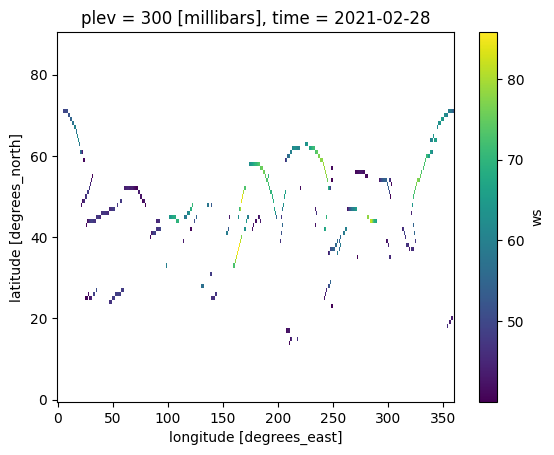

In [24]:
ws_slice.where(initial_jet_core_masks)['ws'].isel(plev=2).plot()

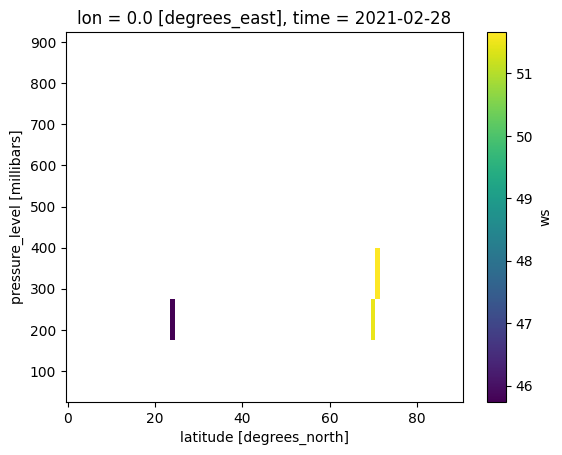

In [25]:
ws_slice.where(initial_jet_core_masks).isel(lon=0)['ws'].plot()

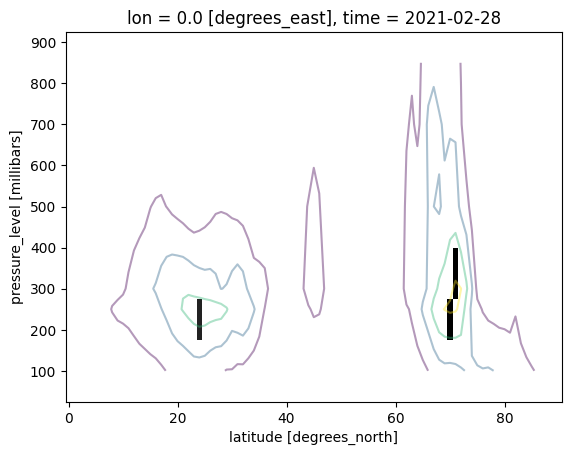

In [26]:
ws_slice['ws'].isel(lon=0).plot.contour(levels=[20, 30, 40, 50], alpha=.4)
ws_slice.where(initial_jet_core_masks).isel(lon=0)['ws'].plot(vmin=0, cmap='Greys',\
                                                              add_colorbar=False)

### Step 3. Get region contour mask to use in subsetting
The 'contour mask' is a variable that is not returned by the original method, but is also included as the user may find it useful   

In [27]:
def get_jet_region_contour_mask(potential_jet_regions, local_maximas):
    """
    Will create a mask based on regions (above ws_threshold) around the jet cores that are
    contiguous.
    The mask will contain categorical values (e.g. 1, 2) for each cluster of jet regions
    contain a jet core. All other values will be 0 (i.e not a jet core or jet region)
    
    Component of method of algorithm originally introduced in Manney et al. (2011) https://doi.org/10.5194/acp-11-6115-2011

    Parameters
    ----------
    potential_jet_regions : xr.DataArray
        Windspeeds of regions above the jet region threshold
        
    local_maximas : np.array
        An array containing values relating to the index of the local maximas (should be the same shape as input: potential_jet_regions)
        
    Returns
    ----------
    jet_region_contour_mask : np.array
        A 2-D array with shape: mask_shape with only the indexes of the local maximas as 1 All other values will 0.
        
    """
    potential_jet_regions_mask , _ = scipy.ndimage.label(potential_jet_regions)
    actual_jet_region_nums = get_jet_region_numbers(local_maximas, potential_jet_regions_mask)
    jet_region_contour_mask = subset_jet_region_mask_to_regions_with_cores(potential_jet_regions_mask, actual_jet_region_nums)
    
    ## Refine jet regions to new values (i.e. if labels have been removed this resets them) 
    jet_region_contour_mask, _ = scipy.ndimage.label(jet_region_contour_mask)
    return jet_region_contour_mask
    
    
def get_jet_region_numbers(local_maximas, potential_jet_regions_mask):
    """
    Will only return clusters ID numbers of jet regions with an actual jet core in them.
    
    Component of method of algorithm originally introduced in Manney et al. (2011) https://doi.org/10.5194/acp-11-6115-2011

    Parameters
    ----------        
    local_maximas : np.array
        An array containing values relating to the index of the local maximas (should be the same shape as input: potential_jet_regions)
    
    potential_jet_regions_mask : numpy.array
        Array of jet regions clusters as returned by scipy.ndimage.label
        
    Returns
    ----------
    actual_jet_region_nums : list
        A list of cluster ID numbers with local maximas in them
    
    """
    actual_jet_region_nums = []
    for i, j in local_maximas:
        valid_region = potential_jet_regions_mask[i, j]
        if not valid_region in actual_jet_region_nums:
            actual_jet_region_nums.append(valid_region)
    return actual_jet_region_nums
            
            
def subset_jet_region_mask_to_regions_with_cores(potential_jet_regions_mask, actual_jet_region_nums):
    """
    Will subset jet region mask to only those with an actual jet core in them.

    Component of method of algorithm originally introduced in Manney et al. (2011) https://doi.org/10.5194/acp-11-6115-2011

    Parameters
    ----------        
    potential_jet_regions_mask : numpy.array
        Array of jet regions clusters as returned by scipy.ndimage.label
        
    actual_jet_region_nums : list
        A list of cluster ID numbers with local maximas in them
    
    Returns
    ----------
    potential_jet_regions_mask : numpy.array
        Subset version of jet regions mask containing only jet region clusters with local maxima in them 

    """
    for reg_num in np.unique(potential_jet_regions_mask):
        if not reg_num in actual_jet_region_nums:
            potential_jet_regions_mask[potential_jet_regions_mask == reg_num] = 0
    return potential_jet_regions_mask

In [28]:
%%time
for ind, lon in enumerate(ws_slice.lon):
    jet_region_contour_mask = get_jet_region_contour_mask(ws_slice['potential_jet_regions'].sel(lon=lon),\
                                                          local_maximas_dict[float(lon)])
    
    # Make the numpy matrix to stack onto using first longitude ws_contour mask
    if ind == 0:
        jet_region_contour_masks = jet_region_contour_mask
        continue
    jet_region_contour_masks = np.dstack([jet_region_contour_masks, jet_region_contour_mask])

CPU times: user 344 ms, sys: 3.82 ms, total: 348 ms
Wall time: 348 ms


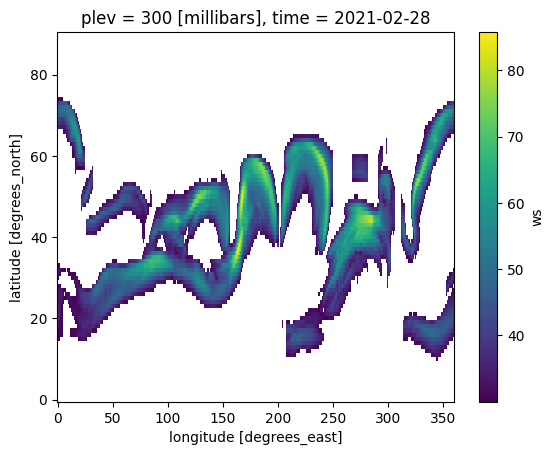

In [29]:
## all these jet regions are above 30 (boundary windspeed threshold) and have a local maxima in them
ws_slice.where(jet_region_contour_masks)['ws'].isel(plev=2).plot()

### Step 4. refine jet regions, so only left, right, above and below of jet core
The jet regions returned by the original method only check for the exceedance of a threshold directly above, below, left and right a local maxima. We replicate and refine the contour regions below to match this.

In [30]:
def refine_jet_region_to_leftright_and_abovebelow(array, x, y):
    """
    This method will remove all values not left, right, above or below the input 
    x, y coordinates in a 2-D array.
    
    Component of method of algorithm originally introduced in Manney et al. (2011) https://doi.org/10.5194/acp-11-6115-2011
    
    Parameters
    ----------
    array : np.array
        A 2-D array with numeric values relating to the jet region (i.e. dtypes float or int)
    x : int
        x-coordinate of a local maxima to subset jet region by
    y: int
        y-coordinate of a local maxima to subset input array by
        
    Returns
    ----------
    refined_array : np.array
        New 2-D array with values only around x and y coordinates

    """
    rows, cols = array.shape
    refined_array = np.zeros_like(array)
    
    if 0 <= x < rows and 0 <= y < cols and array[x, y] != 0:
        # Refine the current cluster
        refined_array[x, y] = array[x, y]
        left_col = y - 1
        while left_col >= 0 and array[x, left_col] != 0:
            refined_array[x, left_col] = array[x, left_col]
            left_col -= 1
        
        right_col = y + 1
        while right_col < cols and array[x, right_col] != 0:
            refined_array[x, right_col] = array[x, right_col]
            right_col += 1
        
        up_row = x - 1
        while up_row >= 0 and array[up_row, y] != 0:
            refined_array[up_row, y] = array[up_row, y]
            up_row -= 1
        
        down_row = x + 1
        while down_row < rows and array[down_row, y] != 0:
            refined_array[down_row, y] = array[down_row, y]
            down_row += 1
    
    return refined_array

In [31]:
%%time
for ind, lon in enumerate(ws_slice.lon):
    jet_region_contour_mask_one_lon = jet_region_contour_masks[::,::,ind]
    jet_region_mask = np.zeros_like(jet_region_contour_mask_one_lon)
    
    current_local_maximas = local_maximas_dict[float(lon)]
    for local_maxima in current_local_maximas:
        refined_result = refine_jet_region_to_leftright_and_abovebelow(jet_region_contour_mask_one_lon, local_maxima[0], local_maxima[1])
        jet_region_mask += refined_result
    
    # Make the numpy matrix to stack onto using first longitude ws_contour mask
    if ind == 0:
        jet_region_masks = jet_region_mask
        continue
    jet_region_masks = np.dstack([jet_region_masks, jet_region_mask])

CPU times: user 80.9 ms, sys: 345 µs, total: 81.2 ms
Wall time: 80.9 ms


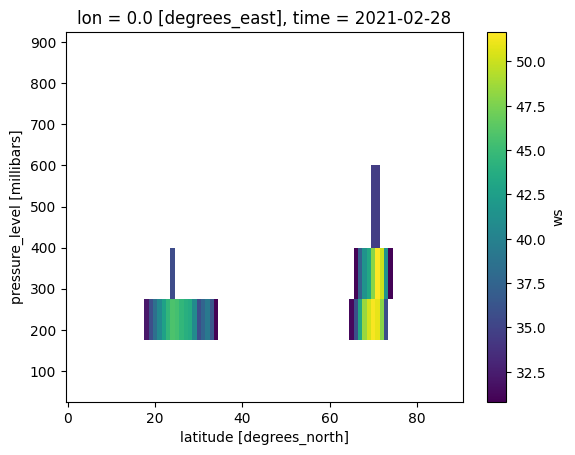

In [32]:
ws_slice.where(jet_region_masks)['ws'].isel(lon=0).plot()

Text(0.5, 1.0, 'contour mask, before refinement')

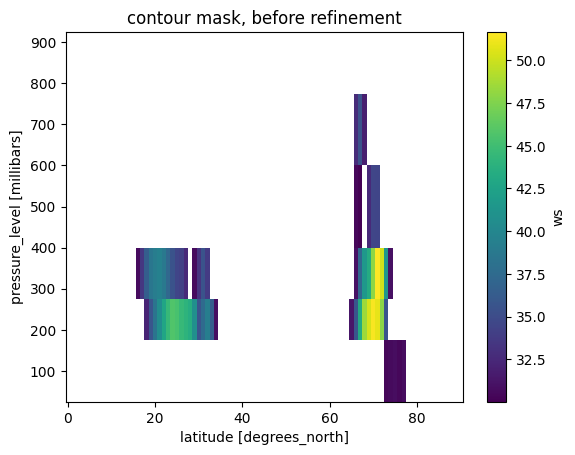

In [33]:
ws_slice.where(jet_region_contour_masks).isel(lon=0)['ws'].plot()
plt.title('contour mask, before refinement')

##### assign these variables to original dataset

In [34]:
ws_slice['jet_region_mask'] = (('plev', 'lat', 'lon'), np.clip(jet_region_masks, 0, 1))
ws_slice['jet_region_above_ws_threshold_mask'] = (('plev', 'lat', 'lon'), jet_region_contour_masks)

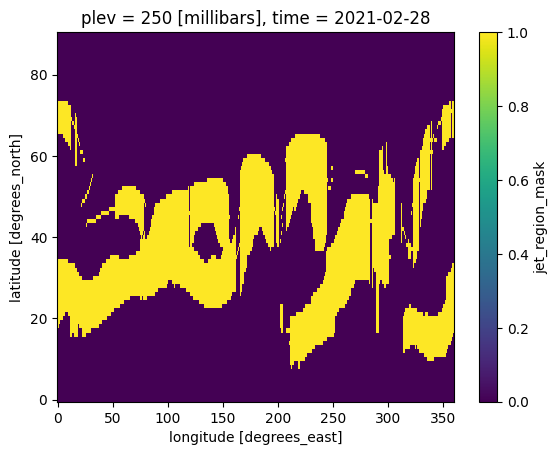

In [35]:
ws_slice['jet_region_mask'].isel(plev=1).plot()

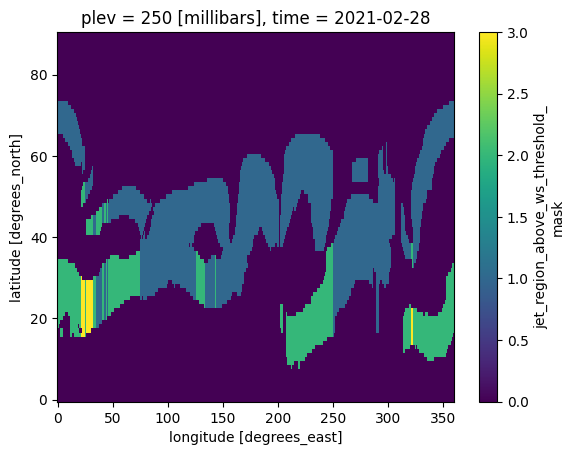

In [36]:
ws_slice['jet_region_above_ws_threshold_mask'].isel(plev=1).plot()

In [37]:
## drop unwanted 
if 'potential_jet_regions' in ws_slice:
    ws_slice = ws_slice.drop('potential_jet_regions')

### Step 5. Run checks on the jet cores to refine them based on two criterea
1. Cores are more than 15 degrees of latitude apart (see variable 'jet_core_lat_distance')  

If they are not, a further check is applied:

2. Windspeed does not drop below 25 m/s in a straight line between two cores (see variable 'ws_drop_threshold')

### Notes about this stage:
- *This method will select the core with fastest windspeed if multiple cores found in same region*

- **No cores?** -> method will select maximum windspeed instead (`index_of_first_maximum`)


<!-- #### to verify
Here we use 'get_values_along_a_line_between_two_coordinates' to interpolate the values between two points in a matrix. Need to check if this is appropriate for the method. -->

In [38]:
## global variables
jet_core_lat_distance = 15
ws_drop_threshold = 25

In [39]:
def get_values_along_a_line_between_two_coordinates(data, start_point, end_point):
    """
    Get all values along a shortest path between two coordinates in a 2-D numpy array.
    
    Component of method of algorithm originally introduced in Manney et al. (2011) https://doi.org/10.5194/acp-11-6115-2011

    Parameters
    ----------
    arr : np.array
        A 2-D array with numeric values (i.e. dtypes float or int)
        
    Returns
    ----------
    local_maxima : np.array
        A 2-D array with values relating to the index of the local maximas
        
    Examples
    ----------
    .. code-block:: python
    
        import numpy as np
        
        # Example array
        data = np.array([
            [1, 2, 3, 4, 5],
            [2, 3, 4, 5, 4],
            [3, 4, 5, 6, 7],
            [4, 5, 6, 7, 6],
            [5, 6, 7, 8, 9]
        ])

        local_maxima_indices = find_local_maxima(data)

        for i, j in local_maxima_indices:
            print(f"Local maximum at ({i}, {j}): {data[i, j]}")
            
    """
    # Calculate the differences in coordinates
    dx = end_point[1] - start_point[1]
    dy = end_point[0] - start_point[0]

    # Calculate the number of steps required for the line
    num_steps = max(abs(dx), abs(dy))

    # Calculate the step sizes for each coordinate
    x_step = dx / num_steps
    y_step = dy / num_steps

    # Initialize lists to store the coordinates along the path
    path_coordinates = []
    for step in range(num_steps + 1):
        row = int(round(start_point[0] + step * y_step))
        col = int(round(start_point[1] + step * x_step))
        path_coordinates.append((row, col))

    # Extract values along the path
    values_along_path = [float(data[row, col]) for row, col in path_coordinates]

    return values_along_path


def has_ws_drop_between_cores(ws_between_cores, ws_drop_threshold):
    """
    Will check for a windspeed drop of a given threshold between cores
    
    Parameters
    ----------
    ws_between_cores : np.array
        A 1-D array with windspeed between two cores as determined by 'get_values_along_a_line_between_two_coordinates'
    ws_drop_threshold : int or float
        Windspeed threshold to check
        
    Returns
    ----------
    out : boolean
        True if windspeeds input have a drop greater than 'ws_drop_threshold'

    """
    if any(ws_between_cores[0] - np.array(ws_between_cores) > ws_drop_threshold):
        return True
    elif any(ws_between_cores[-1] - np.array(ws_between_cores) > ws_drop_threshold):
        return True
    else:
        return False
    
    
def slice_array_by_index_breaks(array_to_slice, index_breaks):
    """
    Will break an array down into segments based on a list of indexes containing information about where to create slices
    
    Parameters
    ----------
    array_to_slice : array-like
        Array to break down based on slice breaks
    index_breaks : array-like
        Indexes from which to slice array

    Returns
    ----------
    output: list
        Broken down slices of original array_to_slice
    """
    return [
        array_to_slice[i:j] for i, j in zip([0] + index_breaks, index_breaks + [None])
    ]


In [40]:
# Example of how split index slices works. Useful for seperating multicores and running checks on them
index_breaks = [1, 3, 4]
array_to_slice = [0, 1, 2, 3, 4, 5, 6]
print(slice_array_by_index_breaks(array_to_slice, index_breaks))

[[0], [1, 2], [3], [4, 5, 6]]


In [41]:
def get_index_of_cores_to_drop_based_on_multicore_regions(local_maxima_ind_slices, current_local_maximas, multi_core_region_ws):   
    """
    Get index of cores to remove in same region based on whether they contain the first occurence of 
    the maximum windspeed or not. 
    
    Parameters
    ----------
    local_maxima_ind_slices : np.array of np.arrays
        Collection of index slices for current local maximas
    current_local_maximas : np.array
        Collection of indexes of current local maxima
    multi_core_region_ws : xr.DataArray
        Data containing region windspeeds
        
    Returns
    ----------
    index_of_cores_to_drop : np.array
        Mask of jet cores in current longitude plev/lat slice with multi core regions formatted
    """
    index_of_cores_to_drop = []
    # Loop through each local_maxima_slice
    for local_maxima_ind_slice in local_maxima_ind_slices:
        if len(local_maxima_ind_slice) <= 1:
            # This would indicate a single core, so will not be removed
            continue
        # Get current max windspeed for region (as fallback). Will select first occurence of max.
        index_of_ws_maxima = get_current_region_ws_maxima_lat_and_plev_ind(current_local_maximas, local_maxima_ind_slice, multi_core_region_ws)

        for ind, local_maxima_ind in enumerate(local_maxima_ind_slice):
            current_local_maxima = current_local_maximas[int(local_maxima_ind)]
            if ind == 0:
                previous_local_maxima = current_local_maxima
                continue
            # Check if current or previous is the maximum (so will need to be retained)
            current_is_index_of_max = np.array_equal(np.array([current_local_maxima[0], current_local_maxima[1]]), index_of_ws_maxima)
            previous_is_index_of_max = np.array_equal(np.array([previous_local_maxima[0], previous_local_maxima[1]]), index_of_ws_maxima)
            # Store index of cores to drop
            if current_is_index_of_max:
                index_of_cores_to_drop.append([previous_local_maxima[0], previous_local_maxima[1]])
            else:
                index_of_cores_to_drop.append([current_local_maxima[0], current_local_maxima[1]])
                if not previous_is_index_of_max:
                    # occurs only if there are 3+ cores in region and maximum is not between current and previous 
                    index_of_cores_to_drop.append([previous_local_maxima[0], previous_local_maxima[1]])
            previous_local_maxima = current_local_maxima
    return index_of_cores_to_drop


def get_current_region_ws_maxima_lat_and_plev_ind(current_local_maximas, local_maxima_ind_slice, multi_core_region_ws):
    """
    Get the plev and lat index of current region windspeed maxima. 
    Will select the first occurence of maxima, if there is more than one (rare).
    
    Parameters
    ----------
    current_local_maximas : np.array
        Collection of indexes of current local maxima
    local_maxima_ind_slice : np.array
        Index slice for current local maxima
    multi_core_region_ws : xr.DataArray
        Data containing region windspeeds
    
    Returns
    ----------
    output : np.array
        Array of the plev and latitude 
    """
    all_current_local_maximas_ind = current_local_maximas[list(local_maxima_ind_slice.astype(int))]
    all_current_local_maximas_data = multi_core_region_ws.isel(plev=all_current_local_maximas_ind[:, 0], lat=all_current_local_maximas_ind[:, 1])
    if all_current_local_maximas_data.isnull().all():
        return []
    max_ws_indices = np.unravel_index(all_current_local_maximas_data.argmax(), all_current_local_maximas_data.shape)
    current_max_data = all_current_local_maximas_data[max_ws_indices[0], max_ws_indices[1]]
    # select first occurence of maximum if multiple
    if current_max_data.size > 1:
        current_max_data = current_max_data[0]
    iplev = list(multi_core_region_ws.plev.values).index(current_max_data.plev)
    ilat = list(multi_core_region_ws.lat.values).index(current_max_data.lat)
    return np.array([iplev, ilat])

In [42]:
%load_ext snakeviz

In [43]:
%%time
jet_core_masks = np.copy(initial_jet_core_masks)
for lon_ind, lon in enumerate(ws_slice.lon[:]):
    initial_jet_core_masks_one_lon = initial_jet_core_masks[:,:,lon_ind]
    jet_region_contour_one_lon = ws_slice['jet_region_above_ws_threshold_mask'].sel(lon=lon)
    ws_one_lon = ws_slice['ws'].sel(lon=lon)
    current_local_maximas = local_maximas_dict[float(lon)]
    
    # sort local maximas by latitude instead of plev (so similar latitudes are compared first)
    current_local_maximas = np.array(sorted(current_local_maximas, key=lambda x: x[1]))
    
    # Get first occurence of the maximum windspeed
    index_of_first_maximum = np.dstack(np.where(ws_one_lon == ws_one_lon.max()))[0]
    
    core_and_location = []
    for core_ind, local_maxima in enumerate(current_local_maximas):
        region_within = jet_region_contour_one_lon[local_maxima[0], local_maxima[1]] # this is the region contour that the jet core is found within
        core_and_location.append([core_ind, float(region_within)])
    core_and_location = np.array(core_and_location)
    if len(core_and_location) == 0:
        # There are no cores found. Select maximum windspeed
        print(f'no cores found for lon: {float(lon)}, using index of first ws maximum') # temporary print statement for this notebook
        core_and_location = index_of_first_maximum
        
    region_ind, num_cores_in_region = np.unique(core_and_location[::,1], return_counts=True)
    multi_core_regions = region_ind[num_cores_in_region > 1]
    for multi_core_region in multi_core_regions:
        # get all the local maxima within regions of multi cores
        local_maxima_inds = core_and_location[::,0][core_and_location[::,1] == multi_core_region]
        # Check 1. Test if cores are more than 15 degrees away
        previous_lat = None
        for local_maxima_ind in local_maxima_inds:
            local_maxima = current_local_maximas[int(local_maxima_ind)]
            if not previous_lat:
                # set previous latitude to check for latitude distance in next
                previous_lat = local_maxima[1]
            else:
                current_lat = local_maxima[1]
                if abs(ws_slice['lat'][previous_lat] -  ws_slice['lat'][current_lat]) > jet_core_lat_distance:
                    previous_lat = current_lat
                    continue

        # Check 2. Test if cores have ws drop between them
        multi_core_region_ws = ws_one_lon.where(jet_region_contour_one_lon == multi_core_region)
        for multi_core_region in multi_core_regions:
            # get all the local maxima within regions of multi cores
            local_maxima_inds = core_and_location[::,0][core_and_location[::,1] == multi_core_region]
            # Step 1 of 2: loop over local maxima in multicore region and find if they need to split further
            slicepoints_in_region = []
            for ind, local_maxima_ind in enumerate(local_maxima_inds):
                current_local_maxima = current_local_maximas[int(local_maxima_ind)]

                if ind == 0:
                    previous_local_maxima = current_local_maxima
                    continue
                windspeeds_between_cores = get_values_along_a_line_between_two_coordinates(\
                                                            multi_core_region_ws,\
                                                            start_point=previous_local_maxima,\
                                                            end_point=current_local_maxima)                
                # Get conditions for dropping cores
                ws_drops_below_threshold = has_ws_drop_between_cores(windspeeds_between_cores, ws_drop_threshold=ws_drop_threshold)
                if ws_drops_below_threshold:
                    slicepoints_in_region.append(ind)
                previous_local_maxima = current_local_maxima

            # Step 2 of 2: Remove cores in same region and retain core with maximum windspeed
            local_maxima_ind_slices = slice_array_by_index_breaks(local_maxima_inds, slicepoints_in_region)
            index_of_cores_to_drop = get_index_of_cores_to_drop_based_on_multicore_regions(local_maxima_ind_slices, current_local_maximas, multi_core_region_ws)
            for index_of_core_to_drop in index_of_cores_to_drop:
                jet_core_masks[index_of_core_to_drop[0], index_of_core_to_drop[1], lon_ind] = 0


no cores found for lon: 201.0, using index of first ws maximum
no cores found for lon: 307.0, using index of first ws maximum
no cores found for lon: 308.0, using index of first ws maximum
no cores found for lon: 309.0, using index of first ws maximum
no cores found for lon: 310.0, using index of first ws maximum
no cores found for lon: 311.0, using index of first ws maximum
CPU times: user 6.25 s, sys: 0 ns, total: 6.25 s
Wall time: 6.25 s


In [44]:
ws_slice['jet_core_mask'] = (('plev', 'lat', 'lon'), jet_core_masks)
if 'potential_jet_cores' in ws_slice:
    ws_slice = ws_slice.drop('potential_jet_cores')

Text(0.5, 1.0, 'before checks')

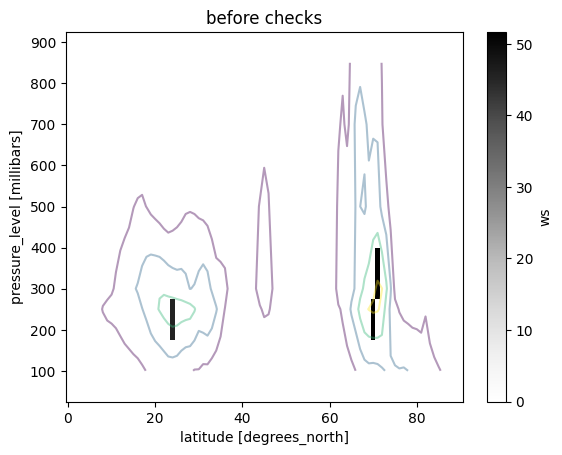

In [45]:
ws_slice['ws'].isel(lon=0).plot.contour(levels=[20, 30, 40, 50], alpha=.4)
ws_slice.where(initial_jet_core_masks)['ws'].isel(lon=0).plot(vmin=0, cmap='Greys')
plt.title('before checks')

Text(0.5, 1.0, 'after checks')

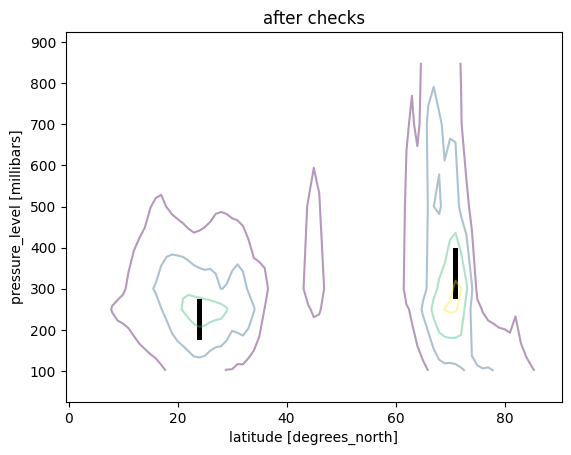

In [46]:
ws_slice['ws'].isel(lon=0).plot.contour(levels=[20, 30, 40, 50], alpha=.4)
ws_slice['jet_core_mask'].isel(lon=0).plot(vmin=0, cmap='Greys',\
                                                              add_colorbar=False)
plt.title('after checks')

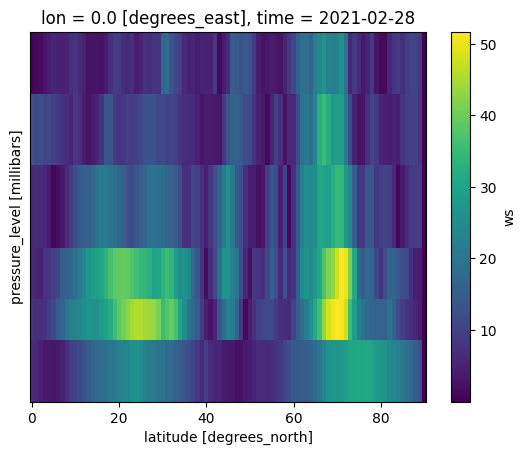

In [47]:
ws_slice['ws'].isel(lon=0).plot()
plt.plot('windspeed slice')

Text(0.5, 1.0, 'after checks with jet region shown too')

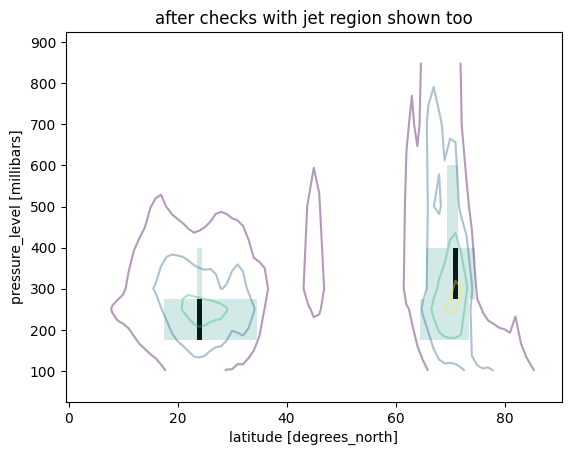

In [48]:
ws_slice['ws'].isel(lon=0).plot.contour(levels=[20, 30, 40, 50], alpha=.4)
(ws_slice['jet_core_mask']/ws_slice['jet_core_mask']).isel(lon=0).plot(vmin=0, cmap='Greys', add_colorbar=False)
(ws_slice['jet_region_mask'].isel(lon=0)/ws_slice['jet_region_mask'].isel(lon=0)).plot(alpha=.2, add_colorbar=False)
plt.title('after checks with jet region shown too')

# EXTRA STUFF (Working out and full method etc.)
## Full method

In [49]:
def manney_et_al_2011(
    data,
    jet_core_plev_limit,
    jet_core_ws_threshold=40,
    jet_boundary_ws_threshold=30,
    ws_drop_threshold=25,
    jet_core_lat_distance=15,
    check_diagonals=False,
):
    r"""
    This method detects jet cores (within an altitude range see 'jet_core_plev_limit') and a boundary region surrounding
    those cores based on two windspeed thresholds. Two checks are applied after initial detection of cores to check whether
    boundaries with more then one core are part of the same feature (the default threshold for these boundaries is 30 m/s,
    see 'jet_boundary_ws_threshold'). The two checks seperate cores based on whether the cores are more than a certain distance apart
    (default is 15 degrees, see 'jet_core_lat_distance') and whether the windspeed between two given cores does not drop
    below a windspeed threshold (default is 25 m/s, see 'ws_drop_threshold')

    This method returns four outputs
        1. **jet_core_mask** -- Regions within each latitude-altitude slice that are local maxima and have windspeeds above the 'jet_core_ws_threshold'
        2. **jet_region_mask** -- Regions above, below, left and right of any given jet core with windspeed above the 'jet_boundary_ws_threshold'
        3. **jet_region_contour_mask** -- All contigious regions of windspeeds emcompassing a jet core above the 'jet_boundary_ws_threshold' (i.e. not just above, below, left and right)
        4. **ws** -- Resultant wind speed calculated from 'ua', 'va' inputs.

    This method was originally introduce in Manney et al. (2011) (https://doi.org/10.5194/acp-11-6115-2011),
    and is described in Section 3.1 of that study. This method is also known as the JETPAC (Jet and
    Tropopause Products for Analysis and Characterization) software package, and available in its original
    form at request to NASA JPL.

    Please see 'Notes' below for any additional information about the implementation of this method
    to this package.

    Parameters
    ----------
    data : xarray.Dataset
        Data which should containing the variables: 'ua' and 'va', and the coordinates: 'lon', 'lat', 'plev' and 'time'.
    jet_core_plev_limit: tuple or array
        Sequence of two values relating to the pressure level limit of the jet cores (original paper uses 100hPa 400 hPa)
    jet_core_ws_threshold : int or float
        Threshold used for jet-stream core point (default=40 m/s)
    jet_boundary_ws_threshold : int or float
        Threshold for jet-stream boundary point (default=30 m/s)
    ws_drop_threshold : int or float
        Threshold for drop in windspeed along the line between cores (default: 25 m/s)
    jet_core_lat_distance : int or float
        Threshold for maximum distance between cores to be counted the same (default: 15 degrees)
    check_diagonals : bool
        Whether to check the diagonal edges of each maxima in the latitude-altitude plane. The original method does not include this (default: False).

    Returns
    ----------
    output : xarray.Dataset
        Data containing the four output variables: 'ws', 'jet_region_mask', 'jet_region_contour_mask', and 'jet_core_mask'

    Notes
    -----
    The implementation of this method varies slightly from the original, because this method will return a mask rather
    than dynamical values, the intention was to allow these masks to be used to subset other variables such as windspeed
    (see 'Examples' for demonstration of how to use the mask).

    There is an update to this method introduced in Manney & Hegglin 2018 to include physically-based method to extract the
    subtropical jet is identified (and thus distinguished from polar jets).

    'jet_region_above_ws_threshold_mask' is provided here as a alternative to using a contour to check which regions
    encompass jet cores.

    Examples
    --------
    .. code-block:: python

        import jsmetrics
        import xarray as xr

        # Load in dataset with u and v components:
        uv_data = xr.open_dataset('path_to_uv_data')

        # Subset dataset to range appropriate for original methodology (100-1000 hPa)):
        uv_sub = uv_data.sel(plev=slice(100, 1900))

        # Run algorithm:
        manney_outputs = jsmetrics.jet_core_algorithms.manney_et_al_2011(uv_sub, ws_core_threshold=40, ws_boundary_threshold=30, jet_core_plev_limit=(100, 400))

        # Use the jet core mask to extract the jet windspeeds
        manney_jet_ws = manney_outputs.where(manney_outputs['jet_core_mask'])['ws']

    """
    # Step 1. Check plev and time coordinate in data
    if "plev" not in data.dims:
        data = data.expand_dims("plev")
    if "time" not in data.coords:
        raise KeyError("Please provide a time coordinate for data to run this metric")

    # Step 2. Check a pressure level limit is provided by the user
    if not jet_core_plev_limit:
        raise KeyError(
            "Please provide a pressure level limit for jet cores returned by this metric. As an example the original methodology used a limit of 100-400 hPa. To replicate this, pass the parameter jet_core_plev_limit=(100, 400)."
        )

    # Step 3. Calculate wind speed from ua and va components.
    data["ws"] = windspeed_utils.get_resultant_wind(data["ua"], data["va"])

    # Step 4. Run Algorithm and return outputs
    if data["time"].size == 1:
        if "time" in data.dims:
            data = data.squeeze("time")
        output = (
            run_jet_core_and_region_algorithm_on_one_day(
                data,
                jet_core_plev_limit,
                jet_core_ws_threshold,
                jet_boundary_ws_threshold,
                ws_drop_threshold,
                jet_core_lat_distance,
                check_diagonals,
            )
        )
    else:
        output = data.groupby("time").map(
            run_jet_core_and_region_algorithm_on_one_day,
            (
                jet_core_plev_limit,
                jet_core_ws_threshold,
                jet_boundary_ws_threshold,
                ws_drop_threshold,
                jet_core_lat_distance,
                check_diagonals,
            ),
        )
    return output

In [50]:
def run_jet_core_and_region_algorithm_on_one_day(
    row,
    jet_core_plev_limit,
    jet_core_ws_threshold,
    jet_boundary_ws_threshold,
    ws_drop_threshold,
    jet_core_lat_distance,
    check_diagonals,
):
    r"""
    This method detects jet cores and defines a boundary region beside those cores based on two windspeed thresholds.
    Two additional checks are applied after initial detection of cores to check whether cores within the same windspeed region
    are part of the same feature (see 'jet_boundary_ws_threshold'). This is achieved by checking whether regions with multiple
    jet cores are more than a certain distance apart (see 'jet_core_lat_distance') and the windspeed between two cores does
    not drop below a threshold (see 'ws_drop_threshold'). This function runs this method on a single time unit.

    This method returns four outputs
        1. 'jet_core_mask' -- Regions within each latitude/altitude that are local maxima have windspeeds above the 'jet_core_ws_threshold'
        2. 'jet_region_mask' -- Regions above, below, left and right of the jet core with windspeed above the 'jet_boundary_ws_threshold'
        3. 'jet_region_above_ws_threshold_mask' -- All contigious regions of windspeeds emcompassing a jet core above the 'jet_boundary_ws_threshold' (i.e. not just above, below, left and right)
        4. 'ws' -- Wind speed calculated from 'ua', 'va' inputs.

    Component of method of algorithm originally introduced in Manney et al. (2011) https://doi.org/10.5194/acp-11-6115-2011

    Parameters
    ----------
    row : xarray.Dataset
        Data of single time unit containing the variables: 'ua' and 'va', and the coordinates: 'lon', 'lat', 'plev'.
    jet_core_plev_limit: tuple or array
        Sequence of two values relating to the pressure level limit of the jet cores (original paper uses (100, 400) hPa).
    jet_core_ws_threshold : int or float
        Threshold used for jet-stream core point.
    jet_boundary_ws_threshold : int or float
        Threshold for jet-stream boundary point.
    ws_drop_threshold : int or float
        Threshold for drop in windspeed along the line between cores.
    jet_core_lat_distance : int or float
        Threshold for maximum distance between cores to be counted the same.
    check_diagonals : bool
        Whether to check the diagonal edges of each maxima in the latitude-altitude plane.

    Returns
    ----------
    row : xarray.Dataset
        Data for one time unit containing four new variables (ws, jet_core_mask, jet_region_mask, jet_region_above_ws_threshold_mask)
    """

    # Step 1. Get potential cores (to later subset) using the wind speed thresholds and jet core pressure level limit.
    row["potential_jet_cores"] = row["ws"].where(
        lambda val: (val >= jet_core_ws_threshold)
        & (val.plev >= min(jet_core_plev_limit))
        & (val.plev <= max(jet_core_plev_limit)),
        0,
    )
    row["potential_jet_regions"] = row["ws"].where(
        lambda val: val >= jet_boundary_ws_threshold, 0
    )

    # Step 2. Get local maximas at each longitude
    local_maximas_dict = get_local_maximas_at_each_longitude(row, check_diagonals)
    
    # Step 3. Loop through the local maximas and make an mask of initial jet cores (not official as some may be in same region, see check in Step X)
    mask_shape = row["ws"].isel(lon=0).shape
    all_jet_core_mask = get_all_jet_core_mask(
        local_maximas_dict=local_maximas_dict, mask_shape=mask_shape
    )

    # Step 4. Loop through contigious regions (here known as jet region contours) and check if a jet core is within them
    all_jet_region_contour_mask = get_all_jet_region_contour_mask(
        row, local_maximas_dict=local_maximas_dict
    )

    # Step 5. Get the jet region around each local maxima only including above, below, left and right of maxima.
    all_jet_regions_mask = get_all_jet_regions_mask(
        row,
        all_jet_region_contour_mask=all_jet_region_contour_mask,
        local_maximas_dict=local_maximas_dict,
    )

    # Step 6. Remove old jet regions and define two outputs (jet_region, region_above_ws_threshold)
    row = row.drop_vars("potential_jet_regions")
    row["jet_region_mask"] = (
        ("plev", "lat", "lon"),
        np.clip(all_jet_regions_mask, 0, 1),
    )
    row["jet_region_contour_mask"] = (
        ("plev", "lat", "lon"),
        all_jet_region_contour_mask,
    )

    # Step 7. Run checks on jet cores, to check if they are part of the same jet feature
    jet_core_masks = run_checks_on_jet_cores_and_return_jet_cores(
        row,
        all_jet_core_mask,
        local_maximas_dict,
        jet_core_lat_distance,
        ws_drop_threshold,
    )

    # Step 8. Remove old and add actual jet core mask
    row = row.drop_vars("potential_jet_cores")
    row["jet_core_mask"] = (("plev", "lat", "lon"), jet_core_masks)
    return row


def get_local_maximas_at_each_longitude(row, check_diagonals):
    """
    Runs 'find_local_maxima_in_2d_dataarray' on each longitude (see docs for find_local_maxima_in_2d_dataarray for more information)

    Parameters
    ----------
    row : xr.DataArray
        Data of single time unit containing the variables: 'potential_jet_cores', and the coordinates: 'lon', 'lat', 'plev'
    check_diagonals : bool
        Whether to check the diagonal edges of each maxima in the latitude-altitude plane.

    Returns
    ----------
    local_maximas_dict : dict
        Keys are longitude coordinates, values are local maxima locations

    """
    local_maximas_dict = {}
    for _, lon in enumerate(row["lon"]):
        pot_core_one_lon = row["potential_jet_cores"].sel(lon=lon)
        if check_diagonals:
            local_maximas = find_local_maxima_in_2d_dataarray_with_diagonals(
                pot_core_one_lon
            )
        else:
            local_maximas = find_local_maxima_in_2d_dataarray(pot_core_one_lon)
        local_maximas_dict[float(lon)] = local_maximas
    return local_maximas_dict


def find_local_maxima_in_2d_dataarray(arr):
    """
    Find indices of local maximas within a 2-D array. Should return two values which relate to the position of local maximas (if any).

    Component of method of algorithm originally introduced in Manney et al. (2011) https://doi.org/10.5194/acp-11-6115-2011

    Parameters
    ----------
    arr : xr.DataArray
        A 2-D array with numeric values (i.e. dtypes float or int)

    Returns
    ----------
    local_maxima : xr.DataArray
        A 2-D array with values relating to the index of the local maximas

    Examples
    ----------
    .. code-block:: python

        import numpy as np
        import xarray as xr

        # Example array
        data = np.array([
            [1, 2, 3, 4, 5],
            [2, 3, 4, 5, 4],
            [3, 4, 5, 6, 7],
            [4, 5, 6, 7, 6],
            [5, 6, 7, 8, 9]
        ])

        # Convert NumPy array to xarray DataArray
        data_array = xr.DataArray(data)

        local_maxima_indices = find_local_maxima_in_2d_dataarray(data_array)

        for i, j in local_maxima_indices:
            print(f"Local maximum at ({i}, {j}): {data_array[i, j]}")

    """
    # Add padding to array to allow edges to be picked up
    arr = data_utils.add_pad_to_array(arr)

    # Calculate neighbors for all interior points
    neighbors = np.stack(
        [
            arr[:-2, 1:-1],  # Above
            arr[2:, 1:-1],  # Below
            arr[1:-1, :-2],  # Left
            arr[1:-1, 2:],  # Right
        ],
        axis=-1,
    )

    # Find local maximas
    interior_maxima = arr[1:-1, 1:-1] > np.max(neighbors, axis=-1)
    interior_indices = np.transpose(np.where(interior_maxima))

    return np.array(interior_indices)


def find_local_maxima_in_2d_dataarray_with_diagonals(arr):
    """
    Find indices of local maximas within a 2-D array with check for the diagonals.
    Should return two values which relate to the position of local maximas (if any).

    Component of method  from Manney et al. (2011) https://doi.org/10.5194/acp-11-6115-2011

    Parameters
    ----------
    arr : xr.DataArray
        A 2-D array with numeric values (i.e. dtypes float or int)

    Returns
    ----------
    local_maxima : xr.DataArray
        A 1-D array with values relating to the index of the local maximas

    Examples
    ----------
    .. code-block:: python

        import numpy as np
        import xarray as xr

        # Example array
        data = np.array([
            [1, 2, 3, 4, 5],
            [2, 3, 4, 5, 4],
            [3, 4, 5, 6, 7],
            [4, 5, 6, 7, 6],
            [5, 6, 7, 8, 9]
        ])

        # Convert NumPy array to xarray DataArray
        data_array = xr.DataArray(data)

        local_maxima_indices = find_local_maxima_in_2d_dataarray_with_diagonals(data_array)

        for i, j in local_maxima_indices:
            print(f"Local maximum at ({i}, {j}): {data_array[i, j]}")

    """
    local_maxima = []

    # Add padding to array to allow edges to be picked up
    arr = data_utils.add_pad_to_array(arr)

    # Calculate neighbors for all interior points
    neighbors = np.stack(
        [
            arr[:-2, 1:-1],  # Above
            arr[2:, 1:-1],  # Below
            arr[1:-1, :-2],  # Left
            arr[1:-1, 2:],  # Right
        ],
        axis=-1,
    )

    # Find local maximas
    interior_maxima = arr[1:-1, 1:-1] > np.max(neighbors, axis=-1)
    interior_indices = np.transpose(np.where(interior_maxima))
    local_maxima.extend([(i, j) for i, j in interior_indices])

    # Check edges and corners
    top_maxima = np.where(arr[1, 1:-1] > np.maximum(arr[0, 1:-1], arr[2, 1:-1]))[0]
    local_maxima.extend([(0, j) for j in top_maxima])
    bottom_maxima = np.where(arr[-2, 1:-1] > np.maximum(arr[-1, 1:-1], arr[-3, 1:-1]))[
        0
    ]
    
    # arr.shape[0] - 3 because padding added to array 
    local_maxima.extend([(arr.shape[0] - 3, j) for j in bottom_maxima])

    left_maxima = np.where(arr[1:-1, 1] > np.maximum(arr[1:-1, 0], arr[1:-1, 2]))[0]
    local_maxima.extend([(i, 0) for i in left_maxima])

    right_maxima = np.where(arr[1:-1, -2] > np.maximum(arr[1:-1, -1], arr[1:-1, -3]))[0]
    local_maxima.extend([(i, arr.shape[1] - 3) for i in right_maxima])

    # Check corners
    if arr[0, 0] > np.maximum(arr[1, 0], arr[0, 1]):
        local_maxima.append((0, 0))
    if arr[0, -1] > np.maximum(arr[1, -1], arr[0, -2]):
        local_maxima.append((0, arr.shape[1] - 3))
    if arr[-1, 0] > np.maximum(arr[-2, 0], arr[-1, 1]):
        local_maxima.append((arr.shape[0] - 3, 0))
    if arr[-1, -1] > np.maximum(arr[-2, -1], arr[-1, -2]):
        local_maxima.append((arr.shape[0] - 3, arr.shape[1] - 3))
    
    # Remove duplicates (this strategy can produce duplicates)
    local_maxima = np.unique(np.array(local_maxima), axis=0)
    return local_maxima


def get_all_jet_core_mask(local_maximas_dict, mask_shape):
    """
    Runs 'create_mask_using_local_maximas' using each

    Component of method of algorithm originally introduced in Manney et al. (2011) https://doi.org/10.5194/acp-11-6115-2011

    Parameters
    ----------
    local_maximas_dict : dict
        Keys are longitude coordinates, values are local maxima locations

    mask_shape : tuple
        Values to create a mask of given shape from
        .
    Returns
    ----------
    all_jet_core_mask : numpy.array
        Mask of the jet cores

    """
    all_jet_core_mask = np.array([])
    for ind, local_maximas in enumerate(local_maximas_dict.values()):
        
        current_jet_core_mask = create_mask_using_local_maximas(
            local_maximas=local_maximas, mask_shape=mask_shape
        )
        if ind == 0:
            all_jet_core_mask = current_jet_core_mask
            continue
        all_jet_core_mask = np.dstack([all_jet_core_mask, current_jet_core_mask])
    return all_jet_core_mask


def create_mask_using_local_maximas(local_maximas, mask_shape):
    """
    Will create a mask with the same dimensions as the inputted mask_shape
    and only the local maxima as value 1. All other values will be 0.

    Component of method of algorithm originally introduced in Manney et al. (2011) https://doi.org/10.5194/acp-11-6115-2011

    Parameters
    ----------
    local_maximas : np.array
        An array containing values relating to the index of the local maximas in a mask with shape: mask_shape

    mask_shape : tuple
        Values to create a mask of given shape from.

    Returns
    ----------
    mask : np.array
        An array with shape: mask_shape with only the indexes of the local maximas as 1 All other values will 0.

    """
    empty_mask = np.zeros(mask_shape)
    for i, j in local_maximas:
        empty_mask[i, j] = 1
    return empty_mask


def get_all_jet_region_contour_mask(row, local_maximas_dict):
    """
    Runs 'get_jet_region_contour_mask' on each longitude in data with one time step

    Component of method of algorithm originally introduced in Manney et al. (2011) https://doi.org/10.5194/acp-11-6115-2011

    Parameters
    ----------
    row : xr.DataArray
        Data of single time unit containing the variables: 'potential_jet_cores', and the coordinates: 'lon', 'lat', 'plev'

    local_maximas : np.array
        An array containing values relating to the index of the local maximas in a mask with shape: mask_shape

    Returns
    ----------
    all_jet_region_contour_mask : np.array
        A 3-D array the indexes (lat, plev) of the local maximas for each longitude as 1 All other values will 0.

    """
    all_jet_region_contour_mask = np.array([])
    for ind, lon in enumerate(row.lon):
        current_jet_region_contour_mask = get_jet_region_contour_mask(
            row["potential_jet_regions"].sel(lon=lon), local_maximas_dict[float(lon)]
        )
        if ind == 0:
            all_jet_region_contour_mask = current_jet_region_contour_mask
            continue
        all_jet_region_contour_mask = np.dstack(
            [all_jet_region_contour_mask, current_jet_region_contour_mask]
        )
    return all_jet_region_contour_mask


def get_jet_region_contour_mask(potential_jet_regions, local_maximas):
    """
    Will create a mask based on regions (above ws_threshold) around the jet cores that are
    contiguous.
    The mask will contain categorical values (e.g. 1, 2) for each cluster of jet regions
    contain a jet core. All other values will be 0 (i.e not a jet core or jet region)

    Component of method of algorithm originally introduced in Manney et al. (2011) https://doi.org/10.5194/acp-11-6115-2011

    Parameters
    ----------
    potential_jet_regions : xr.DataArray
        Windspeeds of regions above the jet region threshold

    local_maximas : np.array
        An array containing values relating to the index of the local maximas (should be the same shape as input: potential_jet_regions)

    Returns
    ----------
    jet_region_contour_mask : np.array
        A 2-D array with shape: mask_shape with only the indexes of the local maximas as 1 All other values will 0.

    """
    potential_jet_regions_mask, _ = scipy.ndimage.label(potential_jet_regions)
    actual_jet_region_nums = get_jet_region_numbers(
        local_maximas, potential_jet_regions_mask
    )
    jet_region_contour_mask = subset_jet_region_mask_to_regions_with_cores(
        potential_jet_regions_mask, actual_jet_region_nums
    )

    # Refine jet regions to new values (i.e. if labels have been removed this resets them)
    jet_region_contour_mask, _ = scipy.ndimage.label(jet_region_contour_mask)
    return jet_region_contour_mask


def get_jet_region_numbers(local_maximas, potential_jet_regions_mask):
    """
    Will only return clusters ID numbers of jet regions with an actual jet core in them.

    Component of method of algorithm originally introduced in Manney et al. (2011) https://doi.org/10.5194/acp-11-6115-2011

    Parameters
    ----------
    local_maximas : np.array
        An array containing values relating to the index of the local maximas (should be the same shape as input: potential_jet_regions)

    potential_jet_regions_mask : numpy.array
        Array of jet regions clusters as returned by scipy.ndimage.label

    Returns
    ----------
    actual_jet_region_nums : list
        A list of cluster ID numbers with local maximas in them

    """
    actual_jet_region_nums = []
    for i, j in local_maximas:
        valid_region = potential_jet_regions_mask[i, j]
        if valid_region not in actual_jet_region_nums:
            actual_jet_region_nums.append(valid_region)
    return actual_jet_region_nums


def subset_jet_region_mask_to_regions_with_cores(
    potential_jet_regions_mask, actual_jet_region_nums
):
    """
    Will subset jet region mask to only those with an actual jet core in them.

    Component of method of algorithm originally introduced in Manney et al. (2011) https://doi.org/10.5194/acp-11-6115-2011

    Parameters
    ----------
    potential_jet_regions_mask : numpy.array
        Array of jet regions clusters as returned by scipy.ndimage.label

    actual_jet_region_nums : list
        A list of cluster ID numbers with local maximas in them

    Returns
    ----------
    potential_jet_regions_mask : numpy.array
        Subset version of jet regions mask containing only jet region clusters with local maxima in them

    """
    for reg_num in np.unique(potential_jet_regions_mask):
        if reg_num not in actual_jet_region_nums:
            potential_jet_regions_mask[potential_jet_regions_mask == reg_num] = 0
    return potential_jet_regions_mask


def get_all_jet_regions_mask(row, all_jet_region_contour_mask, local_maximas_dict):
    """
    Get all jet regions mask by looping over each longitude in row.
    See also docs of 'refine_jet_region_to_leftright_and_abovebelow'

    Component of method of algorithm originally introduced in Manney et al. (2011) https://doi.org/10.5194/acp-11-6115-2011

    Parameters
    ----------
    row : xr.DataArray
        Data of single time unit containing the coordinates: 'lon'

    all_jet_region_contour_mask : np.array
        A 3-D array the indexes (lat, plev) of the local maximas for each longitude as 1 All other values will 0.

    local_maximas_dict : dict
        Keys are longitude coordinates, values are local maxima locations

    Returns
    ----------
    all_jet_regions_mask : np.array
        A refined version of the inputted 'all_jet_region_contour_mask' of the local maximas for each longitude as 1 All other values will 0.

    """
    all_jet_regions_mask = np.array([])  # initialise jet region array
    for ind, lon in enumerate(row.lon):
        current_jet_region_contour_mask_one_lon = all_jet_region_contour_mask[
            ::, ::, ind
        ]
        current_jet_region_mask = np.zeros_like(
            current_jet_region_contour_mask_one_lon
        )  # create empty mask

        current_local_maximas = local_maximas_dict[float(lon)]
        for local_maxima in current_local_maximas:
            refined_result = refine_jet_region_to_leftright_and_abovebelow(
                current_jet_region_contour_mask_one_lon,
                local_maxima[0],
                local_maxima[1],
            )
            current_jet_region_mask += refined_result
        if ind == 0:
            all_jet_regions_mask = current_jet_region_mask
            continue
        all_jet_regions_mask = np.dstack(
            [all_jet_regions_mask, current_jet_region_mask]
        )
    return all_jet_regions_mask


def refine_jet_region_to_leftright_and_abovebelow(array, x, y):
    """
    This method will remove all values not left, right, above or below the input
    x, y coordinates in a 2-D array.

    Component of method of algorithm originally introduced in Manney et al. (2011) https://doi.org/10.5194/acp-11-6115-2011

    Parameters
    ----------
    array : np.array
        A 2-D array with numeric values relating to the jet region (i.e. dtypes float or int)
    x : int
        x-coordinate of a local maxima to subset jet region by
    y: int
        y-coordinate of a local maxima to subset input array by

    Returns
    ----------
    refined_array : np.array
        New 2-D array with values only around x and y coordinates

    """
    rows, cols = array.shape
    refined_array = np.zeros_like(array)

    if 0 <= x < rows and 0 <= y < cols and array[x, y] != 0:
        # Refine the current cluster
        refined_array[x, y] = array[x, y]
        left_col = y - 1
        while left_col >= 0 and array[x, left_col] != 0:
            refined_array[x, left_col] = array[x, left_col]
            left_col -= 1

        right_col = y + 1
        while right_col < cols and array[x, right_col] != 0:
            refined_array[x, right_col] = array[x, right_col]
            right_col += 1

        up_row = x - 1
        while up_row >= 0 and array[up_row, y] != 0:
            refined_array[up_row, y] = array[up_row, y]
            up_row -= 1

        down_row = x + 1
        while down_row < rows and array[down_row, y] != 0:
            refined_array[down_row, y] = array[down_row, y]
            down_row += 1

    return refined_array


def get_values_along_a_line_between_two_coordinates(data, start_point, end_point):
    """
    Get all values along a shortest path between two coordinates in a 2-D numpy array.

    Component of method of algorithm originally introduced in Manney et al. (2011) https://doi.org/10.5194/acp-11-6115-2011

    Parameters
    ----------
    arr : np.array
        A 2-D array with numeric values (i.e. dtypes float or int)

    Returns
    ----------
    local_maxima : np.array
        A 2-D array with values relating to the index of the local maximas

    Examples
    ----------
    .. code-block:: python

        import numpy as np

        # Example array
        data = np.array([
            [1, 2, 3, 4, 5],
            [2, 3, 4, 5, 4],
            [3, 4, 5, 6, 7],
            [4, 5, 6, 7, 6],
            [5, 6, 7, 8, 9]
        ])

        local_maxima_indices = find_local_maxima(data)

        for i, j in local_maxima_indices:
            print(f"Local maximum at ({i}, {j}): {data[i, j]}")

    """
    # Calculate the differences in coordinates
    dx = end_point[1] - start_point[1]
    dy = end_point[0] - start_point[0]

    # Calculate the number of steps required for the line
    num_steps = max(abs(dx), abs(dy))

    # Calculate the step sizes for each coordinate
    x_step = dx / num_steps
    y_step = dy / num_steps

    # Initialize lists to store the coordinates along the path
    path_coordinates = []
    for step in range(num_steps + 1):
        row = int(round(start_point[0] + step * y_step))
        col = int(round(start_point[1] + step * x_step))
        path_coordinates.append((row, col))

    # Extract values along the path
    values_along_path = [float(data[row, col]) for row, col in path_coordinates]

    return values_along_path


def has_ws_drop_between_cores(ws_between_cores, ws_drop_threshold):
    """
    Will check for a windspeed drop of a given threshold between cores

    Parameters
    ----------
    ws_between_cores : np.array
        A 1-D array with windspeed between two cores as determined by 'get_values_along_a_line_between_two_coordinates'
    ws_drop_threshold : int or float
        Windspeed threshold to check

    Returns
    ----------
    out : boolean
        True if windspeeds input have a drop greater than 'ws_drop_threshold'

    """
    if any(ws_between_cores[0] - np.array(ws_between_cores) > ws_drop_threshold):
        return True
    elif any(ws_between_cores[-1] - np.array(ws_between_cores) > ws_drop_threshold):
        return True
    else:
        return False


def slice_array_by_index_breaks(array_to_slice, index_breaks):
    """
    Will break an array down into segments based on a list of indexes containing information about where to create slices

    Parameters
    ----------
    array_to_slice : array-like
        Array to break down based on slice breaks
    index_breaks : array-like
        Indexes from which to slice array

    Returns
    ----------
    output: list
        Broken down slices of original array_to_slice
    """
    return [
        array_to_slice[i:j] for i, j in zip([0] + index_breaks, index_breaks + [None])
    ]


def get_index_of_cores_to_drop_based_on_multicore_regions(local_maxima_ind_slices, current_local_maximas, multi_core_region_ws):   
    """
    Get index of cores to remove in same region based on whether they contain the first occurence of 
    the maximum windspeed or not. 
    
    Parameters
    ----------
    local_maxima_ind_slices : np.array of np.arrays
        Collection of index slices for current local maximas
    current_local_maximas : np.array
        Collection of indexes of current local maxima
    multi_core_region_ws : xr.DataArray
        Data containing region windspeeds
        
    Returns
    ----------
    index_of_cores_to_drop : np.array
        Mask of jet cores in current longitude plev/lat slice with multi core regions formatted
    """
    index_of_cores_to_drop = []
    # Loop through each local_maxima_slice
    for local_maxima_ind_slice in local_maxima_ind_slices:
        if len(local_maxima_ind_slice) <= 1:
            # This would indicate a single core, so will not be removed
            continue
        # Get current max windspeed for region (as fallback). Will select first occurence of max.
        index_of_ws_maxima = get_current_region_ws_maxima_lat_and_plev_ind(current_local_maximas, local_maxima_ind_slice, multi_core_region_ws)

        for ind, local_maxima_ind in enumerate(local_maxima_ind_slice):
            current_local_maxima = current_local_maximas[int(local_maxima_ind)]
            if ind == 0:
                previous_local_maxima = current_local_maxima
                continue
            # Check if current or previous is the maximum (so will need to be retained)
            current_is_index_of_max = np.array_equal(np.array([current_local_maxima[0], current_local_maxima[1]]), index_of_ws_maxima)
            previous_is_index_of_max = np.array_equal(np.array([previous_local_maxima[0], previous_local_maxima[1]]), index_of_ws_maxima)
            # Store index of cores to drop
            if current_is_index_of_max:
                index_of_cores_to_drop.append([previous_local_maxima[0], previous_local_maxima[1]])
            else:
                index_of_cores_to_drop.append([current_local_maxima[0], current_local_maxima[1]])
                if not previous_is_index_of_max:
                    # occurs only if there are 3+ cores in region and maximum is not between current and previous 
                    index_of_cores_to_drop.append([previous_local_maxima[0], previous_local_maxima[1]])
            previous_local_maxima = current_local_maxima
    return index_of_cores_to_drop


def get_current_region_ws_maxima_lat_and_plev_ind(current_local_maximas, local_maxima_ind_slice, multi_core_region_ws):
    """
    Get the plev and lat index of current region windspeed maxima. 
    Will select the first occurence of maxima, if there is more than one (rare).
    
    Parameters
    ----------
    current_local_maximas : np.array
        Collection of indexes of current local maxima
    local_maxima_ind_slice : np.array
        Index slice for current local maxima
    multi_core_region_ws : xr.DataArray
        Data containing region windspeeds
    
    Returns
    ----------
    output : np.array
        Array of the plev and latitude 
    """
    all_current_local_maximas_ind = current_local_maximas[list(local_maxima_ind_slice.astype(int))]
    all_current_local_maximas_data = multi_core_region_ws.isel(plev=all_current_local_maximas_ind[:, 0], lat=all_current_local_maximas_ind[:, 1])
    if all_current_local_maximas_data.isnull().all():
        return []
    max_ws_indices = np.unravel_index(all_current_local_maximas_data.argmax(), all_current_local_maximas_data.shape)
    current_max_data = all_current_local_maximas_data[max_ws_indices[0], max_ws_indices[1]]
    # select first occurence of maximum if multiple
    if current_max_data.size > 1:
        current_max_data = current_max_data[0]
    iplev = list(multi_core_region_ws.plev.values).index(current_max_data.plev)
    ilat = list(multi_core_region_ws.lat.values).index(current_max_data.lat)
    return np.array([iplev, ilat])

    
def run_checks_on_jet_cores_and_return_jet_cores(
    row,
    initial_jet_core_masks,
    local_maximas_dict,
    jet_core_lat_distance,
    ws_drop_threshold,
):
    """
    This method runs two checks on the jet cores to check whether there are regions with multiple jet cores.
    Firstly, it checks whether regions with multiple jet cores are more than a certain distance apart
    (default is 15 degrees, see 'jet_core_lat_distance'), and hence seperate cores.
    Secondly, it will check whether the windspeed between two cores drops below a threshold
    (default is 25 m/s, see 'ws_drop_threshold'), if so it will remove the latter core.

    Component of method of algorithm originally introduced in Manney et al. (2011) https://doi.org/10.5194/acp-11-6115-2011

    Parameters
    ----------
    row : xarray.Dataset
        Data of single time unit containing the variables: 'jet_region_contour_mask', and the coordinates: 'lon', 'lat', 'plev'
    initial_jet_core_masks :
        Initial mask of jet cores to check.
    ws_drop_threshold : int or float
        Threshold for drop in windspeed along the line between cores (default: 25 m/s)
    jet_core_lat_distance : int or float
        Threshold for maximum distance between cores to be counted the same (default: 15 degrees)

    Returns
    ----------
    jet_core_masks : numpy.array
        Final jet cores mask of shape of 'initial_jet_core_masks'.

    """
    jet_core_masks = np.copy(initial_jet_core_masks)
    for lon_ind, lon in enumerate(row.lon):
        jet_region_contour_one_lon = row["jet_region_contour_mask"].sel(lon=lon)
        ws_one_lon = row["ws"].sel(lon=lon)
        current_local_maximas = local_maximas_dict[float(lon)]
        # Get first occurence of the maximum windspeed
        index_of_first_maximum = np.dstack(np.where(ws_one_lon == ws_one_lon.max()))[0]
    
        core_and_location = []
        for core_ind, local_maxima in enumerate(current_local_maximas):
            region_within = jet_region_contour_one_lon[
                local_maxima[0], local_maxima[1]
            ]  # this is the region contour that the jet core is found within
            core_and_location.append([core_ind, float(region_within)])
        core_and_location = np.array(core_and_location)

        if len(core_and_location) == 0:
            # No cores found, so selecting the cell with maximum wind speed for this lon slice
            core_and_location = index_of_first_maximum

        region_ind, num_cores_in_region = np.unique(
            core_and_location[::, 1], return_counts=True
        )
        multi_core_regions = region_ind[num_cores_in_region > 1]

        if len(multi_core_regions) == 0:
            # no multi-core regions found
            continue

        for multi_core_region in multi_core_regions:
            # get all the local maxima within regions of multi cores
            local_maxima_inds = core_and_location[::, 0][
                core_and_location[::, 1] == multi_core_region
            ]

            # Check 1. Test if cores are more than 15 degrees away
            previous_lat = None
            for local_maxima_ind in local_maxima_inds:
                local_maxima = current_local_maximas[int(local_maxima_ind)]
                if not previous_lat:
                    # set previous latitude to check for latitude distance in next
                    previous_lat = local_maxima[1]
                else:
                    current_lat = local_maxima[1]
                    if (
                        abs(row["lat"][previous_lat] - row["lat"][current_lat])
                        > jet_core_lat_distance
                    ):
                        previous_lat = current_lat
                        continue

            # Check 2. Test if cores have ws drop between them
            multi_core_region_ws = ws_one_lon.where(jet_region_contour_one_lon == multi_core_region)
            for multi_core_region in multi_core_regions:
                # get all the local maxima within regions of multi cores
                local_maxima_inds = core_and_location[::,0][core_and_location[::,1] == multi_core_region]
                # Step 1 of 2: loop over local maxima in multicore region and find if they need to split further
                slicepoints_in_region = []
                for ind, local_maxima_ind in enumerate(local_maxima_inds):
                    current_local_maxima = current_local_maximas[int(local_maxima_ind)]
                    if ind == 0:
                        previous_local_maxima = current_local_maxima
                        continue
                    windspeeds_between_cores = get_values_along_a_line_between_two_coordinates(\
                                                                multi_core_region_ws,\
                                                                start_point=previous_local_maxima,\
                                                                end_point=current_local_maxima)                
                    # Get conditions for dropping cores
                    ws_drops_below_threshold = has_ws_drop_between_cores(windspeeds_between_cores, ws_drop_threshold=ws_drop_threshold)
                    if ws_drops_below_threshold:
                        slicepoints_in_region.append(ind)
                    previous_local_maxima = current_local_maxima
                # Step 2 of 2: Remove cores in same region and retain core with maximum windspeed
                local_maxima_ind_slices = slice_array_by_index_breaks(local_maxima_inds, slicepoints_in_region)
                index_of_cores_to_drop = get_index_of_cores_to_drop_based_on_multicore_regions(local_maxima_ind_slices, current_local_maximas, multi_core_region_ws)
                for index_of_core_to_drop in index_of_cores_to_drop:
                    jet_core_masks[index_of_core_to_drop[0], index_of_core_to_drop[1], lon_ind] = 0
    return jet_core_masks


In [51]:
%%time
out = manney_et_al_2011(uava, jet_core_plev_limit=(100, 300))

CPU times: user 7min 59s, sys: 672 ms, total: 8min
Wall time: 8min


In [52]:
out['jet_core_mask'].astype(float).max()

<xarray.DataArray 'jet_core_mask' ()>
array(1.)

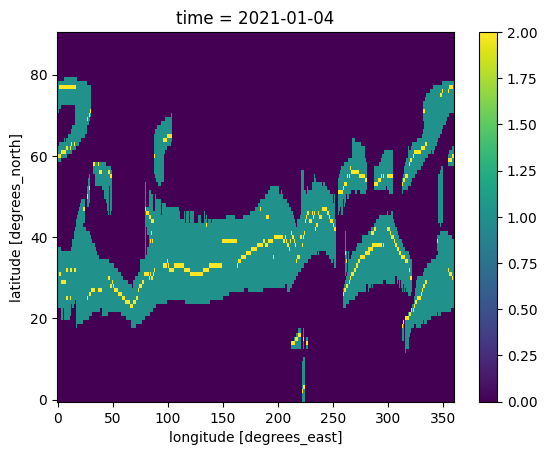

In [53]:
(out['jet_region_mask'].isel(time=3).max('plev') + out['jet_core_mask'].isel(time=3).max('plev')).plot()

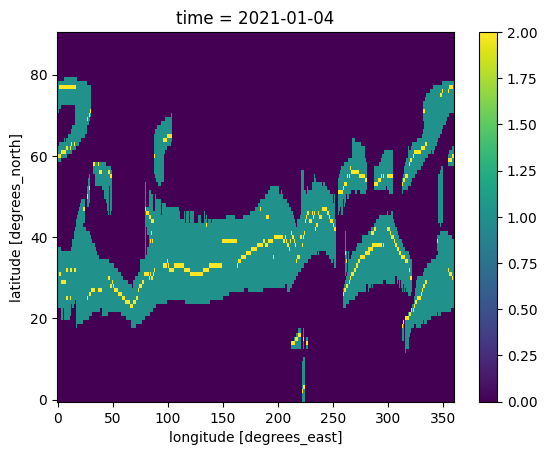

In [54]:
(out['jet_region_mask'].isel(time=3).max('plev') + out['jet_core_mask'].isel(time=3).max('plev')).plot()

### with diagonal local maxima check

In [55]:
%%time
dout = manney_et_al_2011(uava, jet_core_plev_limit=(100, 300), check_diagonals=True)

CPU times: user 10min 10s, sys: 731 ms, total: 10min 10s
Wall time: 10min 12s


In [56]:
dout['jet_core_mask'].astype(float).max()

<xarray.DataArray 'jet_core_mask' ()>
array(1.)

Text(0.5, 1.0, 'without diagonal check')

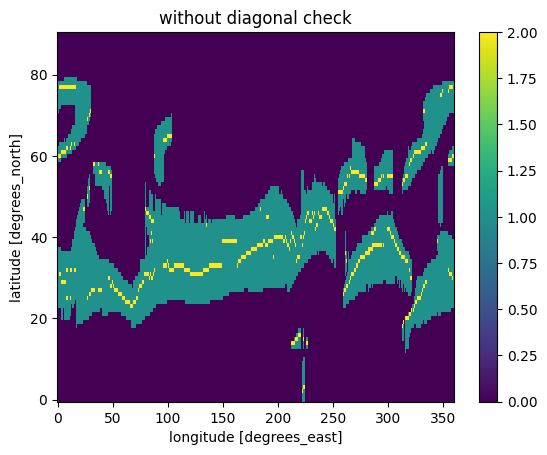

In [57]:
(out['jet_region_mask'].isel(time=3).max('plev') + out['jet_core_mask'].isel(time=3).max('plev')).plot()
plt.title("without diagonal check")

Text(0.5, 1.0, 'with diagonal check')

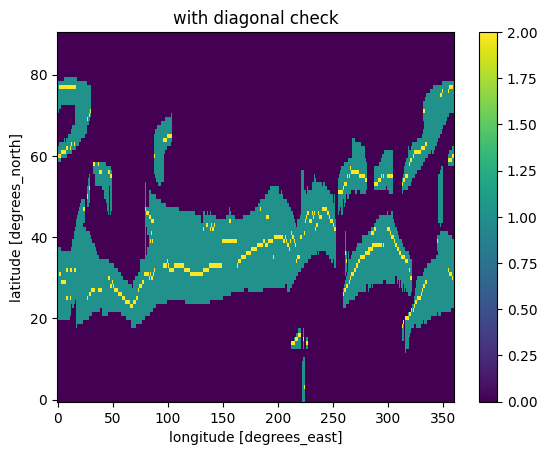

In [58]:
(dout['jet_region_mask'].isel(time=3).max('plev') + dout['jet_core_mask'].isel(time=3).max('plev')).plot()
plt.title("with diagonal check")